https://github.com/OceanParcels/parcels/blob/master/parcels/examples/tutorial_SummedFields.ipynb

# --> SMOC tides

# 14 days

# SMOC dataset is processed here:
http://localhost:9000/notebooks/WOC_ESA/2022-01-31-parcels_Tides_saving_SMOC_subset_2011.ipynb

### --> SMOC datset is not available in 2011, so randomly chose year 2016 to convert the year in the above dataset to do a first trial

In [1]:
from parcels import Field, FieldSet, ParticleSet, JITParticle,  AdvectionRK4, ErrorCode, DiffusionUniformKh
import numpy as np
from datetime import timedelta, datetime

In [2]:
data_path_v01 = '/storage/shared/oceanparcels/input_data/ESA_WorldOceanCirculation/NorthAtlantic/'
fname_v01 = 'runWOC_NATL_4lb_v1_201109*.nc' #runWOC_NATL_4lb_v1_20110901.nc

In [3]:
filenames = {'U': data_path_v01 + fname_v01, 'V': data_path_v01 + fname_v01}
variables = {'U': 'utot', 'V': 'vtot'}
dimensions = {'U': {'lat': 'lat', 'lon': 'lon', 'time': 'time', 'depth': 'depth'},
              'V': {'lat': 'lat', 'lon': 'lon', 'time': 'time', 'depth': 'depth'}}
indices = {'depth': [0]} # choosing 00m depth
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, indices)


In [4]:
!ncdump -h /storage/shared/oceanparcels/input_data/CMEMS/GLOBAL_ANALYSIS_FORECAST_PHY_001_024_SMOC/SMOC_20211031_R20211101.nc

netcdf SMOC_20211031_R20211101 {
dimensions:
	longitude = 4320 ;
	latitude = 2041 ;
	depth = 1 ;
	time = UNLIMITED ; // (24 currently)
variables:
	float longitude(longitude) ;
		longitude:valid_min = -180.f ;
		longitude:long_name = "longitude coordinate" ;
		longitude:standard_name = "longitude" ;
		longitude:units = "degrees_east" ;
		longitude:step = 0.08332825 ;
	float latitude(latitude) ;
		latitude:valid_max = 90.f ;
		latitude:valid_min = -80.f ;
		latitude:long_name = "latitude coordinate" ;
		latitude:standard_name = "latitude" ;
		latitude:units = "degrees_north" ;
		latitude:step = 0.08332825 ;
	float depth(depth) ;
		depth:valid_min = 0.494025f ;
		depth:valid_max = 0.494025f ;
		depth:long_name = "Depth" ;
		depth:standard_name = "depth" ;
		depth:units = "m" ;
		depth:positive = "down" ;
	float time(time) ;
		time:units = "hours since 1950-01-01 0:0:0" ;
		time:calendar = "standard" ;
		time:long_name = "time" ;
		time:standard_name = "time" ;
		time:step = 1LL ;
	float u

# Creating the tides fieldset:
(Trying with new time)

In [4]:
#!cp /storage/shared/oceanparcels/output_data/data_LauraGN/WOC/Oil/v02/SMOC_tides_sept2016_to_2011_smallSMALL.nc /storage/shared/oceanparcels/output_data/data_LauraGN/WOC/Oil/v02/SMOC_tides_sept2016_to_2011_part1.nc

In [5]:
data_path_v03 = '/storage/shared/oceanparcels/output_data/data_LauraGN/WOC/Oil/v02/'
fname_v03 = 'SMOC_tides_sept2016_to_2011_part*.nc'

In [6]:
filenames_t = {'U': data_path_v03 + fname_v03, 'V': data_path_v03 + fname_v03}
variables_t = {'U': 'utide', 'V': 'vtide'}
dimensions_t = {'U': {'lat': 'latitude', 'lon': 'longitude', 'time': 'time', 'depth': 'depth'},
              'V': {'lat': 'latitude', 'lon': 'longitude', 'time': 'time', 'depth': 'depth'}}
indices_t = {'depth': [0]} # choosing 00m depth

fieldset_tides = FieldSet.from_netcdf(filenames_t, variables_t, dimensions_t, indices_t)


/nethome/gomez023/parcels/parcels/field.py:248: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  timeslices = np.array(timeslices)
/nethome/gomez023/parcels/parcels/field.py:250: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataFiles = np.concatenate(np.array(dataFiles))


In [7]:
fieldset_sum = FieldSet(U=fieldset.U + fieldset_tides.U, V=fieldset.V+fieldset_tides.V)


# Particle release:

In [8]:
npart = 20
lonp = 7 * np.ones(npart)
latp = [i for i in np.linspace(55, 57, npart)]

In [9]:
depp = lonp.copy()
depp[:] = 0.


In [10]:
timep = datetime(2011,9,10)

In [11]:
pset_v2 = ParticleSet(fieldset=fieldset_sum, pclass=JITParticle, lon=lonp, lat=np.array(latp), depth=depp, time=timep)


In [12]:
outdir =  "/storage/shared/oceanparcels/output_data/data_LauraGN/WOC/Oil/v02/"
file_name = "test_v01_Tides_14days.nc"
# file_name = "20110910000000-WOC-L4-CURlag-NATL_oil_spill_drift_1H_00m_instantaneous-v1.0-fv1.0.nc"

In [13]:
def DeleteParticle(particle, fieldset, time):
    particle.delete()

In [14]:
output_file = pset_v2.ParticleFile(name=outdir + file_name, outputdt=timedelta(hours=1))

pset_v2.execute(pset_v2.Kernel(AdvectionRK4), runtime=timedelta(days=14.), dt=timedelta(minutes=10),
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle}, output_file=output_file)

# start_time = timep.isoformat()
# # Check in case it's not NaN:
# print(pset_v2.particle_data['time'][0]) #modify to assert 
# time_unit_out= "seconds since " + str(pset_v2.time_origin)
# end_time = (num2date(pset_v2.particle_data['time'][0], time_unit_out)).isoformat()

# add_WOC_nc_attbts(output_file, start_time, end_time, -75.0, 20., 48., 80.
#         , input_filename="WOC-L4-CUReul-NATL-1H: runWOC_NATL_4lb_v1_201109*.nc"
#         , ntitle="North Atlantic 2D horizontal drift of Oil for ESA WOC project" 
#         , summary="This dataset contains the positions of virtual particles released on 10/09/2011 at 0m representing the trajectories of oil in the North Atlantic."
#         , inid = "NATL_OIL_SPILL_DRIFT_1H_INST"
#         , ndepth = "0")

output_file.export()  # exports the trajectory data to a netcdf file


sh: None: command not found
INFO: Compiled ArrayJITParticleAdvectionRK4 ==> /tmp/parcels-319202/lib8920378bb1feca60575c852f182ba6b4_0.so
INFO: Temporary output files are stored in /storage/shared/oceanparcels/output_data/data_LauraGN/WOC/Oil/v02/out-RNVAIRDX.
INFO: You can use "parcels_convert_npydir_to_netcdf /storage/shared/oceanparcels/output_data/data_LauraGN/WOC/Oil/v02/out-RNVAIRDX" to convert these to a NetCDF file during the run.
100% (1209600.0 of 1209600.0) |##########| Elapsed Time: 0:54:05 Time:  0:54:05


In [17]:
!ls -trl /storage/shared/oceanparcels/output_data/data_LauraGN/WOC/Oil/v02/

total 8500148
drwxr-xr-x 3 gomez023 U_UPG_Gomez023_P         23 Feb  2 16:21 out-NTPQPOHN
-rw-r--r-- 1 gomez023 U_UPG_Gomez023_P     198683 Feb  2 16:30 test_v01_Diffusion_01.nc
-rw-r--r-- 1 gomez023 U_UPG_Gomez023_P     198683 Feb  2 16:34 test_v01_01.nc
drwxr-xr-x 3 gomez023 U_UPG_Gomez023_P         23 Feb  2 16:59 out-ALJBKTHP
drwxr-xr-x 3 gomez023 U_UPG_Gomez023_P         23 Feb  2 16:59 out-SWWDCLWP
-rw-r--r-- 1 gomez023 U_UPG_Gomez023_P     198683 Feb  2 17:33 test_v01_Diffusion_02.nc
-rw-r--r-- 1 gomez023 U_UPG_Gomez023_P 2427459368 Feb  2 18:15 SMOC_tides_sept2016_to_2011_small.nc
drwxr-xr-x 3 gomez023 U_UPG_Gomez023_P         23 Feb  2 18:18 out-LWLMAUTP
drwxr-xr-x 3 gomez023 U_UPG_Gomez023_P         23 Feb  2 18:24 out-IXNCFJXY
drwxr-xr-x 3 gomez023 U_UPG_Gomez023_P         23 Feb  2 18:39 out-FFXETFHO
-rw-r--r-- 1 gomez023 U_UPG_Gomez023_P 2427459368 Feb  2 18:47 SMOC_tides_sept2016_to_2011_smallSMALL.nc
drwxr-xr-x 3 gomez023 U_UPG_Gomez023_P         23 Feb  2 18:47 out-TVWY

In [18]:
!ncdump -h /storage/shared/oceanparcels/output_data/data_LauraGN/WOC/Oil/v02/test_v01_Tides_14days.nc


netcdf test_v01_Tides_14days {
dimensions:
	obs = 337 ;
	traj = 20 ;
variables:
	int64 trajectory(traj, obs) ;
		trajectory:_FillValue = -9223372036854775808LL ;
		trajectory:long_name = "Unique identifier for each particle" ;
		trajectory:cf_role = "trajectory_id" ;
	double time(traj, obs) ;
		time:_FillValue = NaN ;
		time:long_name = "" ;
		time:standard_name = "time" ;
		time:units = "seconds since 2011-09-01T00:00:00.000000000" ;
		time:calendar = "standard" ;
		time:axis = "T" ;
	float lat(traj, obs) ;
		lat:_FillValue = NaNf ;
		lat:long_name = "" ;
		lat:standard_name = "latitude" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
	float lon(traj, obs) ;
		lon:_FillValue = NaNf ;
		lon:long_name = "" ;
		lon:standard_name = "longitude" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
	float z(traj, obs) ;
		z:_FillValue = NaNf ;
		z:long_name = "" ;
		z:standard_name = "depth" ;
		z:units = "m" ;
		z:positive = "down" ;

// global attributes:
		:feature_type = "trajectory"

In [1]:
from datetime import timedelta, datetime
from glob import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from matplotlib import colors 

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
ds_orig = xr.open_dataset('/storage/shared/oceanparcels/output_data/data_LauraGN/WOC/Oil/v02/test_v01_01.nc')
ds_diff_02 = xr.open_dataset('/storage/shared/oceanparcels/output_data/data_LauraGN/WOC/Oil/v02/test_v01_Tides_14days.nc')


/opt/apps/miniconda3/envs/parcels-dev/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/apps/miniconda3/envs/parcels-dev/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


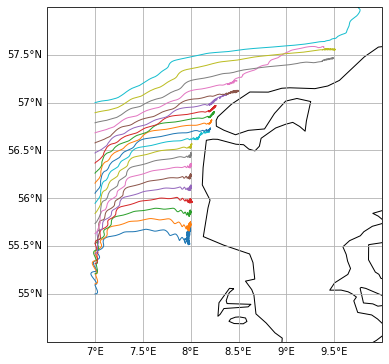

In [23]:
plt.figure(figsize=(6,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ax1.plot(ds_diff_02['lon'].T, ds_diff_02['lat'].T, '-', linewidth=1, transform=ccrs.PlateCarree()) #marker='o'
ax1.set_xlim([6.5, 10])
ax1.set_ylim([54.5, 58])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

/opt/apps/miniconda3/envs/parcels-dev/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/apps/miniconda3/envs/parcels-dev/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/opt/apps/miniconda3/envs/parcels-dev/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/apps/miniconda3/envs/parcels-dev/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels 

Text(0.5, 1.0, 'Previous trajectories with tides')

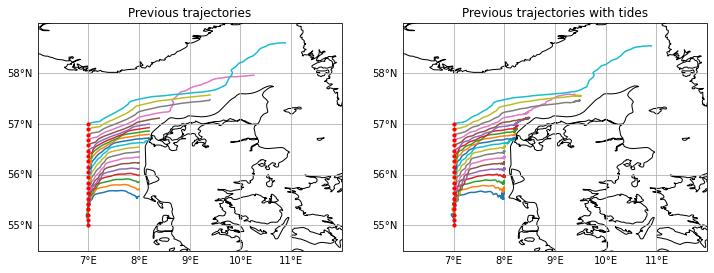

In [5]:
plt.figure(figsize=(12,10)) #(17,5)

ax1 = plt.subplot(121, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='10m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ax1.plot(ds_orig['lon'].T, ds_orig['lat'].T, transform=ccrs.PlateCarree()) #marker='o'
ax1.scatter(ds_orig['lon'][:,0], ds_orig['lat'][:,0], c='r', s=10, transform=ccrs.PlateCarree(), zorder=200) #marker='o'
ax1.set_xlim([6., 12])
ax1.set_ylim([54.5, 59])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax1.set_title('Previous trajectories')

ax1 = plt.subplot(122, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='10m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ax1.plot(ds_diff_02['lon'].T, ds_diff_02['lat'].T, transform=ccrs.PlateCarree()) #marker='o'
ax1.scatter(ds_orig['lon'][:,0], ds_orig['lat'][:,0], c='r', s=10, transform=ccrs.PlateCarree(), zorder=200) #marker='o'
ax1.set_xlim([6., 12])
ax1.set_ylim([54.5, 59])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax1.set_title('Previous trajectories with tides')


In [4]:
ds_tides_15 = xr.open_dataset('/storage/shared/oceanparcels/output_data/data_LauraGN/WOC/Oil/v02/test_v01_Tides_15m_14days_inst.nc')


/opt/apps/miniconda3/envs/parcels-dev/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/opt/apps/miniconda3/envs/parcels-dev/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


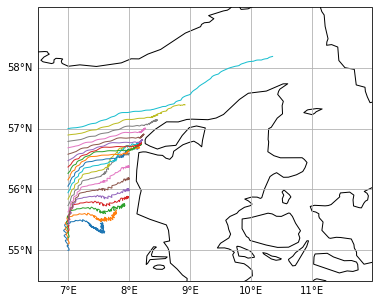

In [7]:
plt.figure(figsize=(6,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ax1.plot(ds_tides_15['lon'].T, ds_tides_15['lat'].T, '-', linewidth=1, transform=ccrs.PlateCarree()) #marker='o'
ax1.set_xlim([6.5, 12])
ax1.set_ylim([54.5, 59])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER